## CAPSTONE PROJECT


## By: Adejare, Ezekiel Sanyaolu


## Question


Completion requirements
Opened: Friday, 9 January 2026, 11:30 AM
Due: Saturday, 31 January 2026, 11:59 PM
About the project

You have been appointed as the Lead Data Analyst to build a predictive model to determine if a building will have an insurance claim during a certain period or not. You will have to predict the probability of having at least one claim over the insured period of the building. The model will be based on the building characteristics. The target variable, Claim, is a:

1 if the building has at least a claim over the insured period.
0 if the building doesn’t have a claim over the insured period.

You have the data description and the training data too

Ensure you do all the necessary data preprocessing to improve your result, and evaluate too

Also, your work should be added as a project to your GitHub repository. The link to the repository that has your notebook(s) is what is expected to be submitted.

A good project contains

1. A good data cleaning and preprocessing
2. ⁠A detailed and explained set of insights through Exploratory Data Analysis
3. ⁠A well-experimented preprocessing for modelling
4. ⁠Implement more than 1 model
5. ⁠Evaluate the models


## Brief Introduction


Accurate prediction of whether a building will have at least one insurance claim during its insured period helps insurers price risk, allocate capital, and design targeted loss-prevention strategies. This project develops a supervised binary classification pipeline that estimates the probability a building files at least one claim during the insured period using available building- and policy-level features.

### Objective

Build, validate, and document a reproducible predictive model that outputs calibrated claim probabilities for individual buildings. Emphasis is on robust data cleaning, thoughtful feature engineering, handling class imbalance, model comparison, and clear evaluation.

### Dataset

- Primary file: Train_data.csv (building and policy features).
- Supplement: Variable Description.csv (feature definitions).
- Expect mixed numeric and categorical features, some malformed entries and missing values (e.g., 'NumberOfWindows' contains non-numeric tokens).
- Rows: ~7k; target is imbalanced.

### Target variable

- Claim: binary (1 if at least one claim during insured period, 0 otherwise).
- Task: predict probability P(Claim = 1).

### Scope & Deliverables

- Cleaned and preprocessed dataset (missing-value strategy, type fixes, outlier handling).
- Exploratory Data Analysis with insights and visualizations.
- Feature engineering (categorical encoding, derived features, scaling).
- Address class imbalance (SMOTE or alternative).
- Train and compare multiple models (baseline logistic regression, tree-based models, hyperparameter tuning).
- Evaluation using threshold-independent and threshold-dependent metrics.
- Final selected model with interpretation and recommended next steps.
- Notebook and scripts pushed to a GitHub repository with README and reproducibility notes.

### Approach & Workflow

1. Data loading and schema inspection.
2. Cleaning: fix types, normalize values, impute missing values (mode/median/advanced where appropriate), remove/transform identifiers.
3. EDA: distributions, correlations, target-wise comparisons, cardinality checks.
4. Feature engineering: one-hot/target encoding for categoricals, date-derived features, scaling numeric features, interaction features as needed.
5. Split into train/test (stratified); handle imbalance on training set (SMOTE used here).
6. Model training: logistic regression (interpretable baseline), random forest (nonlinear baseline), optionally gradient boosting.
7. Hyperparameter tuning via cross-validated GridSearchCV on balanced training data (refit on primary metric).
8. Evaluation on hold-out test set: accuracy, precision, recall, F1, AUC-ROC; calibration checks and ROC curves.
9. Model comparison, selection, and practical deployment notes.

### Evaluation metrics & selection criteria

- Primary: AUC-ROC for ranking; F1 and recall prioritized if the business values capturing claims.
- Secondary: precision, accuracy, calibration (Brier score / reliability plots).
- Use confusion-matrix driven thresholds for operational decisioning.

### Reproducibility & Environment

- Notebook records library versions; use deterministic seeds (random_state) for splitting, sampling, and model initialization.
- Save preprocessing pipeline and final model (pickle/joblib) and include instructions in README for running end-to-end.

### Assumptions & Limitations

- Features provided are sufficient proxies for claim risk; external exposures (weather, claims history beyond insured period) are not included.
- Imputation and synthetic oversampling introduce modeling assumptions—results should be validated with business stakeholders and, if possible, out-of-sample temporal validation.

### Next steps / Recommendations

- Perform calibration and consider Platt scaling/isotonic regression if probabilities are used for pricing.
- Evaluate gradient boosting (e.g., XGBoost/LightGBM) and SHAP for interpretability.
- If available, add temporal validation and external risk factors to improve generalization.


## Problem and Purpose


Problem: Predict whether a building will have at least one insurance claim during the insured period (binary target: Claim = 1/0) using building characteristics and related features.

Purpose: Build and evaluate predictive models to estimate claim probability, enabling better risk pricing, underwriting decisions, and targeted loss-prevention measures. The notebook will cover data cleaning, EDA, feature engineering, handling class imbalance, model training, tuning, and evaluation.


## Libraries Importation


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE


## Data Loading and Initial Inspection

Load the provided 'Train_data.csv' and 'Variable Description.csv' files and perform an initial inspection to understand their structure and content. This includes checking data types, missing values, and a glimpse of the data distribution.


First, load the 'Train_data.csv' file into a pandas DataFrame and display its first 5 rows to get an initial understanding of its structure and content. Then, print a concise summary of the DataFrame using .info() to check data types and non-null values. Finally, calculate and display the number of missing values for each column using .isnull().sum() to identify any data quality issues.


In [2]:
# Load 'Train_data.csv'
df_train = pd.read_csv('Train_data.csv')


In [3]:
df_train.head()


,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


In [4]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7153 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7054 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   6652 non-null   float64
 11  NumberOfWindows     7160 non-null   object 
 12  Geo_Code            7058 non-null   object 
 13  Claim               7160 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 783.3+ KB


In [5]:
print(df_train.isnull().sum())


Customer Id             0
YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Garden                  7
Settlement              0
Building Dimension    106
Building_Type           0
Date_of_Occupancy     508
NumberOfWindows         0
Geo_Code              102
Claim                   0
dtype: int64


Now that the initial inspection for 'Train_data.csv' is complete, I will load the 'Variable Description.csv' file, display its first 5 rows to understand its structure, print its concise summary to check data types and non-null values, and calculate the number of missing values for each column to identify any data quality issues in this second file.


In [6]:
# Load 'Variable Description.csv'
df_variable_desc = pd.read_csv('Variable Description.csv')

print("First 5 rows of Variable Description.csv:")
print(df_variable_desc.head())

print("\nInfo of Variable Description.csv:")
df_variable_desc.info()

print("\nMissing values in Variable Description.csv:")
print(df_variable_desc.isnull().sum())


First 5 rows of Variable Description.csv:
            Variable                                        Description
0        Customer Id        Identification number for the Policy holder
1  YearOfObservation         year of observation for the insured policy
2     Insured_Period  duration of insurance policy in Olusola Insura...
3        Residential      is the building a residential building or not
4   Building_Painted  is the building painted or not (N-Painted, V-N...

Info of Variable Description.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Variable     14 non-null     object
 1   Description  14 non-null     object
dtypes: object(2)
memory usage: 356.0+ bytes

Missing values in Variable Description.csv:
Variable       0
Description    0
dtype: int64


## Data Cleaning and Preprocessing

To clean the training data by handling missing values, correcting inconsistencies, and addressing any data quality issues. This step also includes necessary data type conversions. First, I'll inspect the unique values in the 'NumberOfWindows' column to identify any non-numeric entries, as this column is currently an object type but is expected to be numeric.


In [7]:
print("Unique values in 'NumberOfWindows' column before conversion:")
print(df_train['NumberOfWindows'].unique())


Unique values in 'NumberOfWindows' column before conversion:
['   .' '4' '3' '2' '5' '>=10' '6' '7' '9' '8' '1']


Based on the inspection of unique values, I will now convert the 'NumberOfWindows' column to a numeric data type, coercing any non-numeric values (like ' .' and '>=10') to NaN, to prepare it for imputation or further numerical analysis.


In [8]:
df_train['NumberOfWindows'] = df_train['NumberOfWindows'].str.strip() # Remove leading/trailing spaces
df_train['NumberOfWindows'] = df_train['NumberOfWindows'].replace({'>=10': '10', '   .': pd.NA})
df_train['NumberOfWindows'] = pd.to_numeric(df_train['NumberOfWindows'], errors='coerce')

print("Unique values in 'NumberOfWindows' column after conversion:")
print(df_train['NumberOfWindows'].unique())
print("Data type of 'NumberOfWindows' column after conversion:")
print(df_train['NumberOfWindows'].dtype)


Unique values in 'NumberOfWindows' column after conversion:
[nan  4.  3.  2.  5. 10.  6.  7.  9.  8.  1.]
Data type of 'NumberOfWindows' column after conversion:
float64


Following the data cleaning, I will now impute the missing values in the 'Garden' column using its mode to maintain the most frequent category.


In [9]:
mode_garden = df_train['Garden'].mode()[0]
df_train['Garden'] = df_train['Garden'].fillna(mode_garden)

print("Missing values in 'Garden' column after imputation:")
print(df_train['Garden'].isnull().sum())


Missing values in 'Garden' column after imputation:
0


Next, I will impute the missing values in the 'Building Dimension' column using its median, as this is a numerical column and the median is robust to outliers, ensuring data quality for further analysis.


In [10]:
median_building_dimension = df_train['Building Dimension'].median()
df_train['Building Dimension'] = df_train['Building Dimension'].fillna(median_building_dimension)

print("Missing values in 'Building Dimension' column after imputation:")
print(df_train['Building Dimension'].isnull().sum())


Missing values in 'Building Dimension' column after imputation:
0


Following the data cleaning instructions, I will now impute the missing values in the 'Date_of_Occupancy' column using its median, as it is a numerical column and the median is a robust measure against outliers.


In [11]:
median_date_of_occupancy = df_train['Date_of_Occupancy'].median()
df_train['Date_of_Occupancy'] = df_train['Date_of_Occupancy'].fillna(median_date_of_occupancy)

print("Missing values in 'Date_of_Occupancy' column after imputation:")
print(df_train['Date_of_Occupancy'].isnull().sum())


Missing values in 'Date_of_Occupancy' column after imputation:
0


**Reasoning**:
Next, I will impute the missing values in the 'Geo_Code' column using its mode, as this is a categorical column and the mode imputation will maintain the most frequent category.


In [12]:
mode_geo_code = df_train['Geo_Code'].mode()[0]
df_train['Geo_Code'] = df_train['Geo_Code'].fillna(mode_geo_code)

print("Missing values in 'Geo_Code' column after imputation:")
print(df_train['Geo_Code'].isnull().sum())


Missing values in 'Geo_Code' column after imputation:
0


All specified missing values have been handled in the previous steps. Now, I will verify that there are no remaining missing values in the df_train DataFrame by displaying the sum of nulls for all columns.


In [13]:
mode_geo_code = df_train['Geo_Code'].mode()[0]
df_train['Geo_Code'] = df_train['Geo_Code'].fillna(mode_geo_code)

print("Missing values in 'Geo_Code' column after imputation:")
print(df_train['Geo_Code'].isnull().sum())

print("Missing values in df_train after all imputations:")
print(df_train.isnull().sum())


Missing values in 'Geo_Code' column after imputation:
0
Missing values in df_train after all imputations:
Customer Id              0
YearOfObservation        0
Insured_Period           0
Residential              0
Building_Painted         0
Building_Fenced          0
Garden                   0
Settlement               0
Building Dimension       0
Building_Type            0
Date_of_Occupancy        0
NumberOfWindows       3551
Geo_Code                 0
Claim                    0
dtype: int64


Given that the 'NumberOfWindows' column still has 3551 missing values after previous conversions, I will now impute these missing numerical values using the median of the column. The median is a robust measure suitable for numerical data that might contain outliers.


In [14]:
median_number_of_windows = df_train['NumberOfWindows'].median()
df_train['NumberOfWindows'] = df_train['NumberOfWindows'].fillna(median_number_of_windows)

print("Missing values in 'NumberOfWindows' column after imputation:")
print(df_train['NumberOfWindows'].isnull().sum())


Missing values in 'NumberOfWindows' column after imputation:
0


## **Exploratory Data Analysis (EDA)**


In [15]:
df_train.describe()


,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Claim
count,7160.000000,7160.000000,7160.000000,7160.000000,7160.000000,7160.000000,7160.000000,7160.000000
mean,2013.669553,0.909758,0.305447,1871.873184,2.186034,1964.849721,4.167598,0.228212
std,1.383769,0.239756,0.460629,2263.296186,0.940632,34.730347,1.296028,0.419709
min,2012.000000,0.000000,0.000000,1.000000,1.000000,1545.000000,1.000000,0.000000
25%,2012.000000,0.997268,0.000000,531.500000,2.000000,1960.000000,4.000000,0.000000
50%,2013.000000,1.000000,0.000000,1083.000000,2.000000,1970.000000,4.000000,0.000000
75%,2015.000000,1.000000,1.000000,2250.000000,3.000000,1980.000000,4.000000,0.000000
max,2016.000000,1.000000,1.000000,20940.000000,4.000000,2016.000000,10.000000,1.000000


In [16]:
numerical_cols = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df_train.select_dtypes(include=['object']).columns.tolist()

print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)


Numerical Columns: ['YearOfObservation', 'Insured_Period', 'Residential', 'Building Dimension', 'Building_Type', 'Date_of_Occupancy', 'NumberOfWindows', 'Claim']
Categorical Columns: ['Customer Id', 'Building_Painted', 'Building_Fenced', 'Garden', 'Settlement', 'Geo_Code']


Now that the numerical columns have been identified, I will create histograms for each to visualize their distributions, identify skewness, and detect potential outliers, which is crucial for understanding the data's underlying structure. I will exclude 'Claim' from this visualization as it is the target variable.


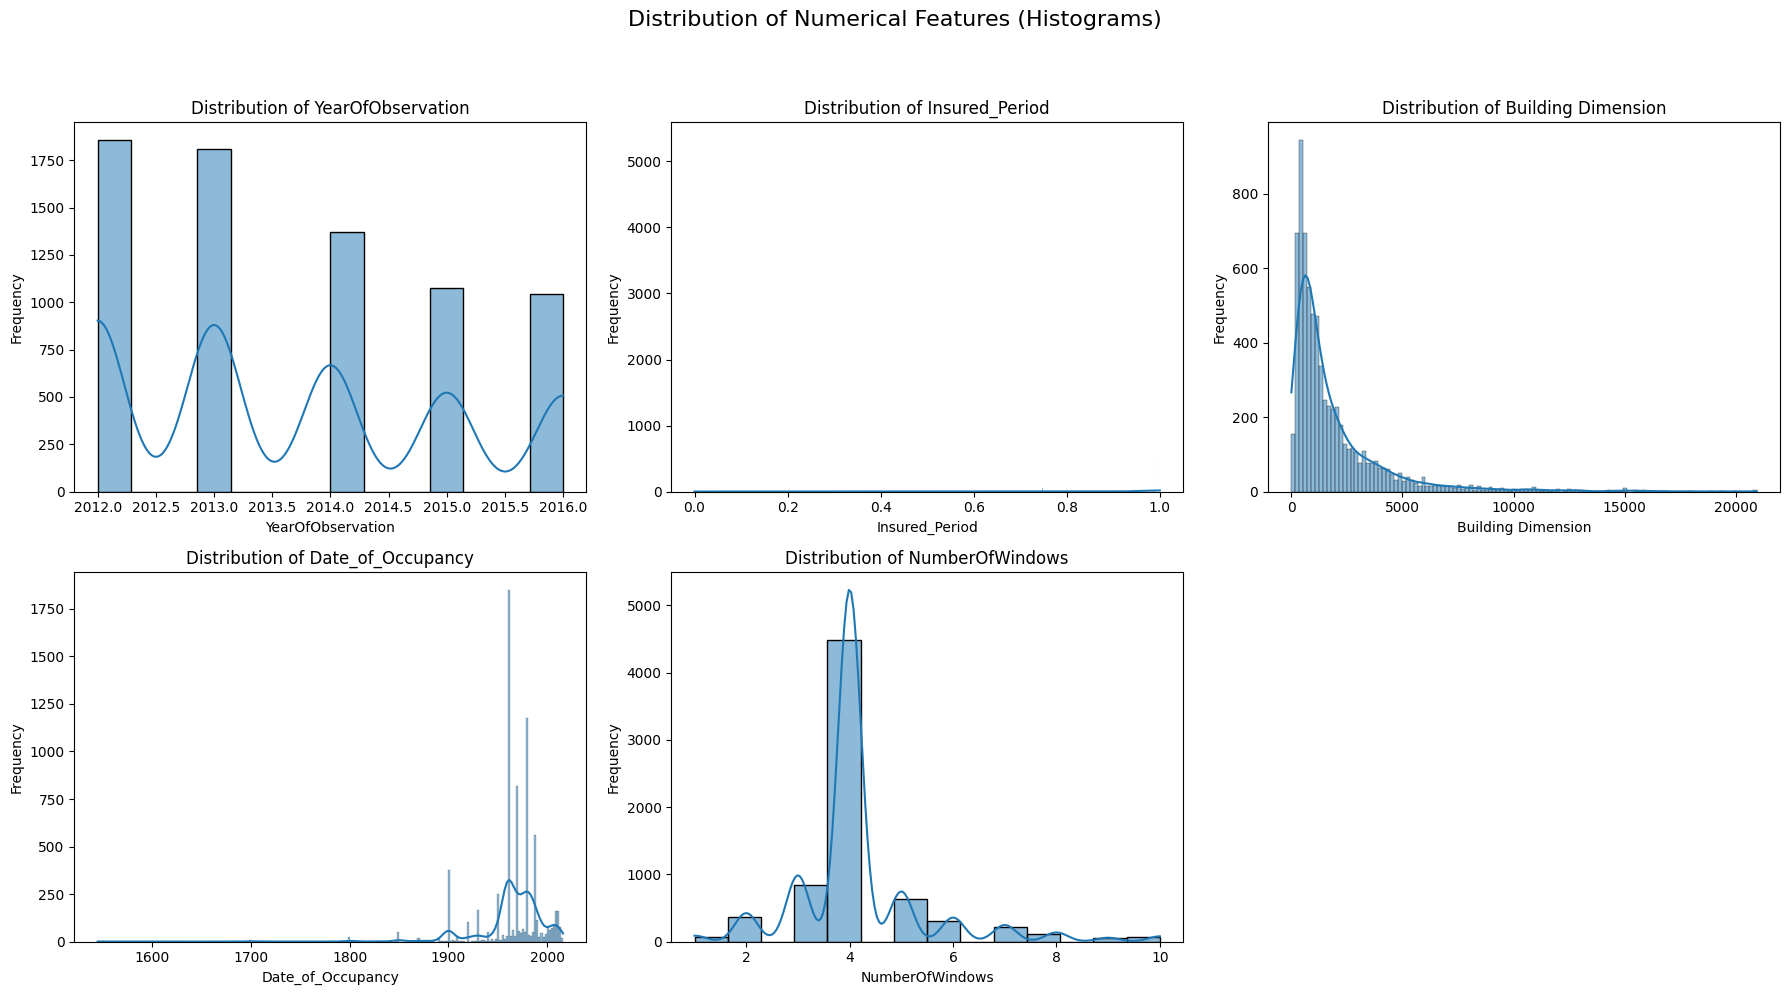

In [17]:
# Exclude 'Claim' from numerical columns for distribution plots as it's the target variable
# Also exclude 'Residential' and 'Building_Type' for now as they are numerical but actually categorical
plot_numerical_cols = [col for col in numerical_cols if col not in ['Claim', 'Residential', 'Building_Type']]

# Set up the matplotlib figure and axes for subplots
num_plots = len(plot_numerical_cols)
num_rows = (num_plots + 2) // 3  # Aim for 3 columns per row

plt.figure(figsize=(18, num_rows * 5))
plt.suptitle('Distribution of Numerical Features (Histograms)', y=1.02, fontsize=16)

for i, col in enumerate(plot_numerical_cols):
    plt.subplot(num_rows, 3, i + 1) # Create subplots dynamically
    sns.histplot(df_train[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent overlap
plt.show()



Next, I will create count plots for the categorical columns to visualize the frequency of each category. I will exclude 'Customer Id' and 'Geo_Code' from these plots due to their high cardinality, which makes them unsuitable for immediate frequency visualization.


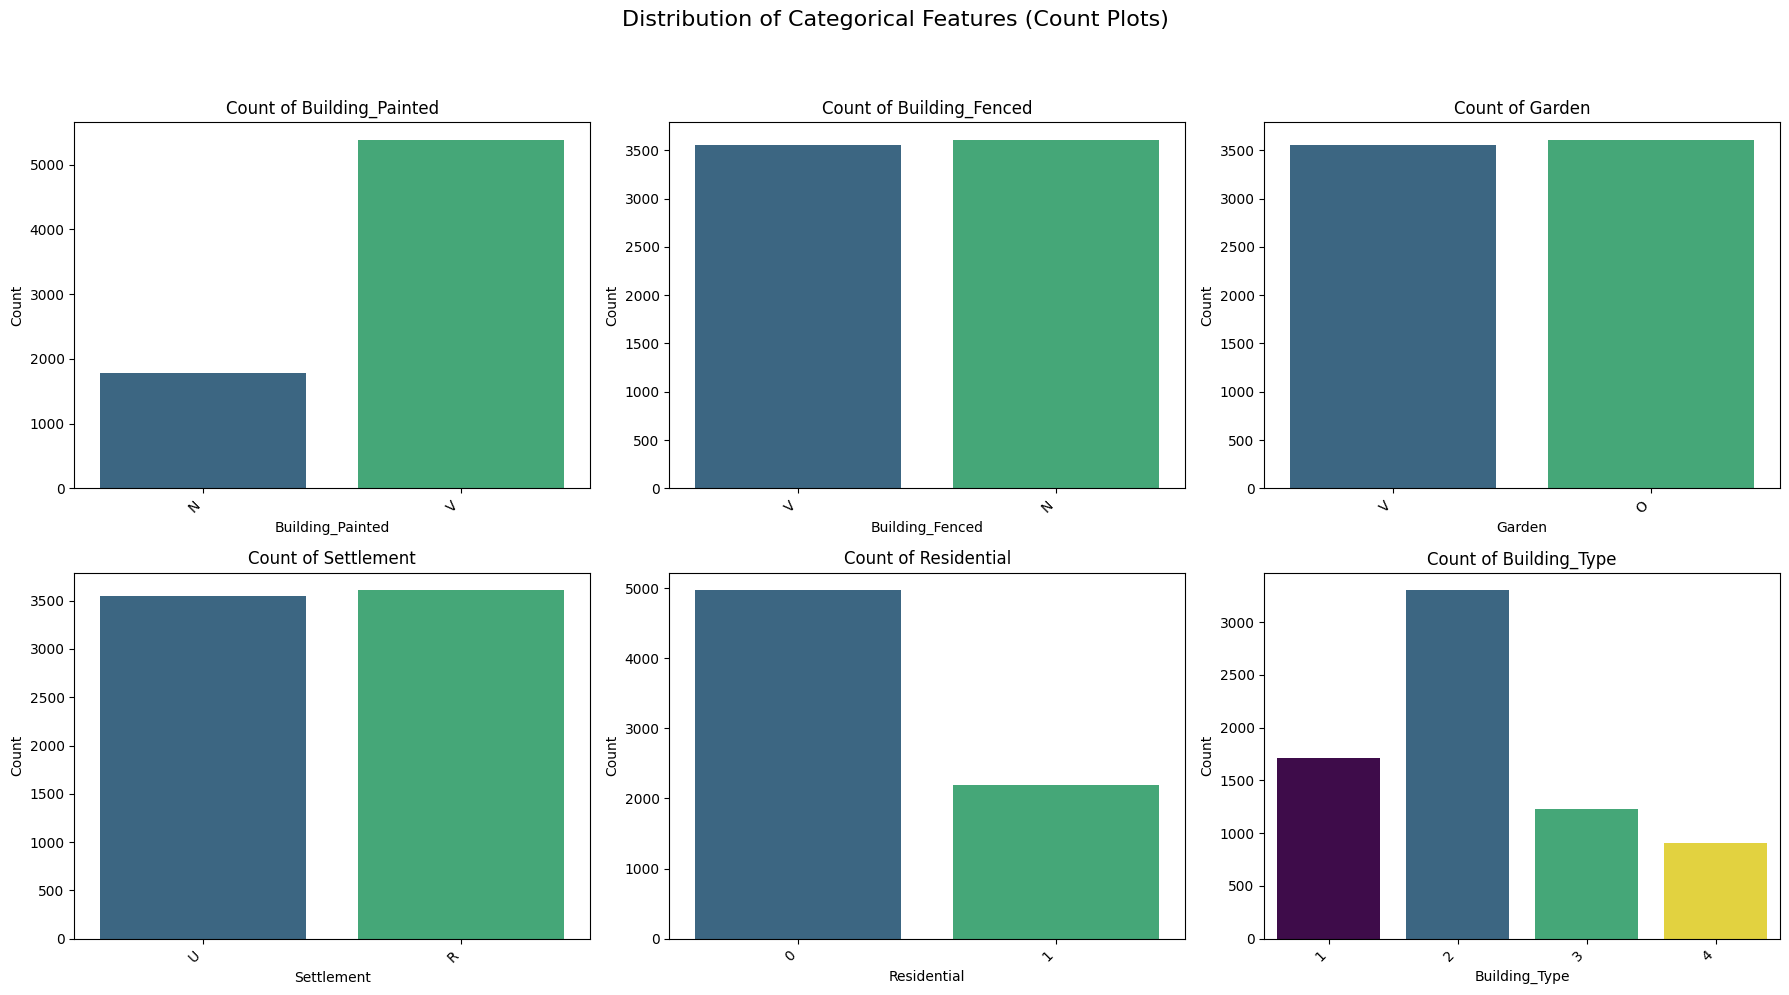

In [18]:
# Exclude 'Customer Id' and 'Geo_Code' from categorical columns for count plots
plot_categorical_cols = [col for col in categorical_cols if col not in ['Customer Id', 'Geo_Code']]

# Add 'Residential' and 'Building_Type' to categorical_cols for plotting
plot_categorical_cols.append('Residential')
plot_categorical_cols.append('Building_Type')

# Set up the matplotlib figure and axes for subplots
num_plots = len(plot_categorical_cols)
num_rows = (num_plots + 2) // 3  # Aim for 3 columns per row

plt.figure(figsize=(18, num_rows * 5))
plt.suptitle('Distribution of Categorical Features (Count Plots)', y=1.02, fontsize=16)

for i, col in enumerate(plot_categorical_cols):
    plt.subplot(num_rows, 3, i + 1)
    sns.countplot(data=df_train, x=col, hue=col, palette='viridis', legend=False)
    plt.title(f'Count of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()


Now, I will create box plots for the key numerical features against the target variable 'Claim' to visually compare the distribution of these features between buildings with and without claims, helping to identify potential predictive relationships.


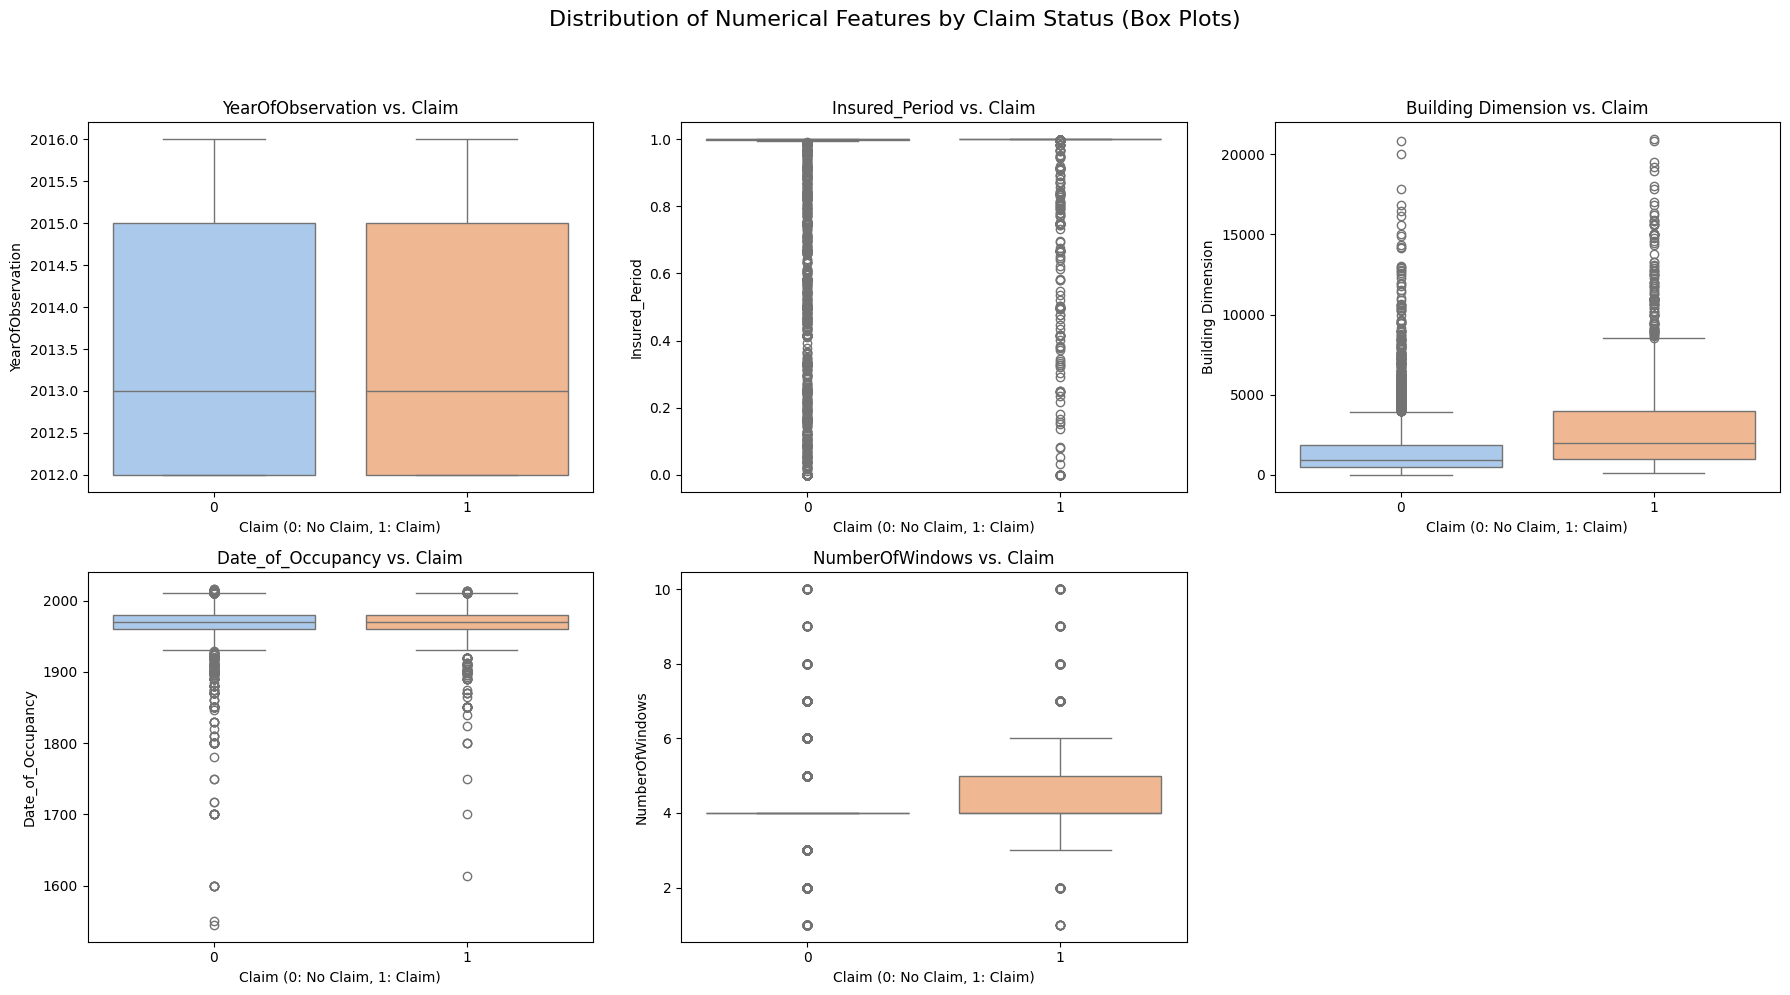

In [19]:
# Set up the matplotlib figure and axes for subplots
num_plots = len(plot_numerical_cols)
num_rows = (num_plots + 2) // 3 # Aim for 3 columns per row

plt.figure(figsize=(18, num_rows * 5))
plt.suptitle('Distribution of Numerical Features by Claim Status (Box Plots)', y=1.02, fontsize=16)

for i, col in enumerate(plot_numerical_cols):
    plt.subplot(num_rows, 3, i + 1)
    sns.boxplot(data=df_train, x='Claim', y=col, hue='Claim', palette='pastel', legend=False)
    plt.title(f'{col} vs. Claim')
    plt.xlabel('Claim (0: No Claim, 1: Claim)')
    plt.ylabel(col)

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()


Next, I will create count plots for the key categorical features against the target variable 'Claim' to observe the proportion of claims within each category, providing insight into which categories might be more prone to claims.


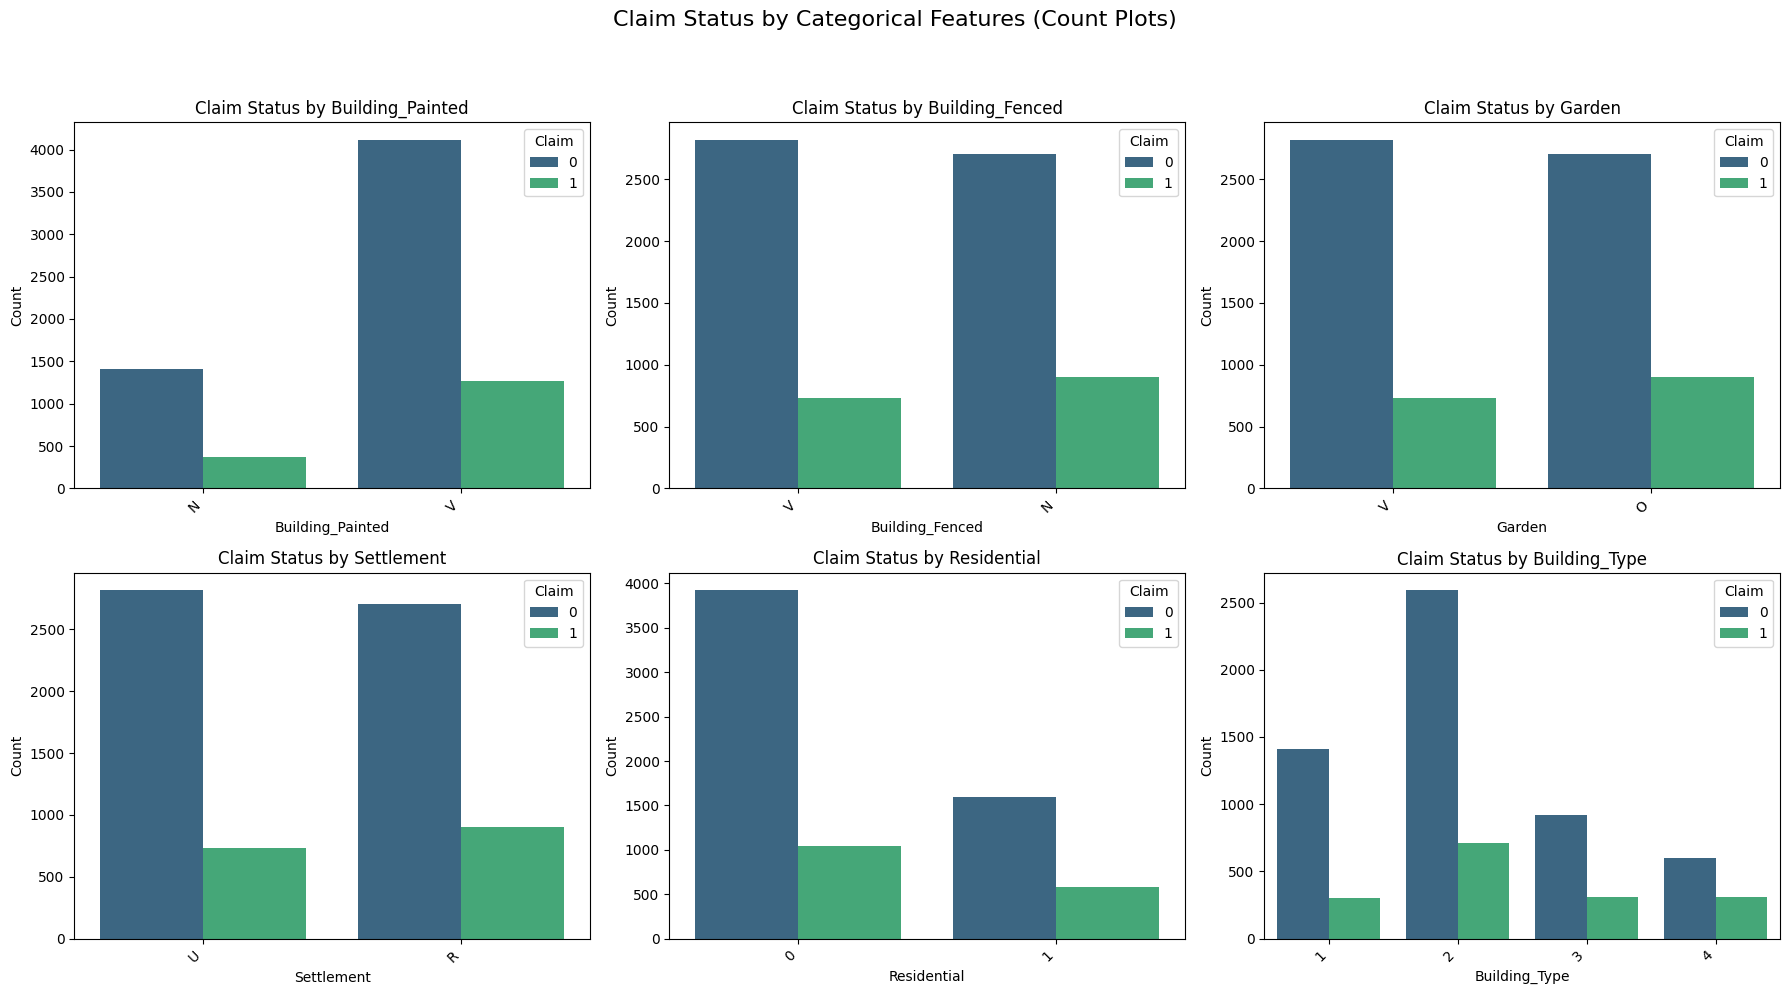

In [20]:
# Set up the matplotlib figure and axes for subplots
num_plots = len(plot_categorical_cols)
num_rows = (num_plots + 2) // 3  # Aim for 3 columns per row

plt.figure(figsize=(18, num_rows * 5))
plt.suptitle('Claim Status by Categorical Features (Count Plots)', y=1.02, fontsize=16)

for i, col in enumerate(plot_categorical_cols):
    plt.subplot(num_rows, 3, i + 1)
    sns.countplot(data=df_train, x=col, hue='Claim', palette='viridis')
    plt.title(f'Claim Status by {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Claim')

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()


Next, I will calculate the correlation matrix for all numerical features in `df_train` to understand the relationships between them and visualize it using a heatmap for better interpretability.


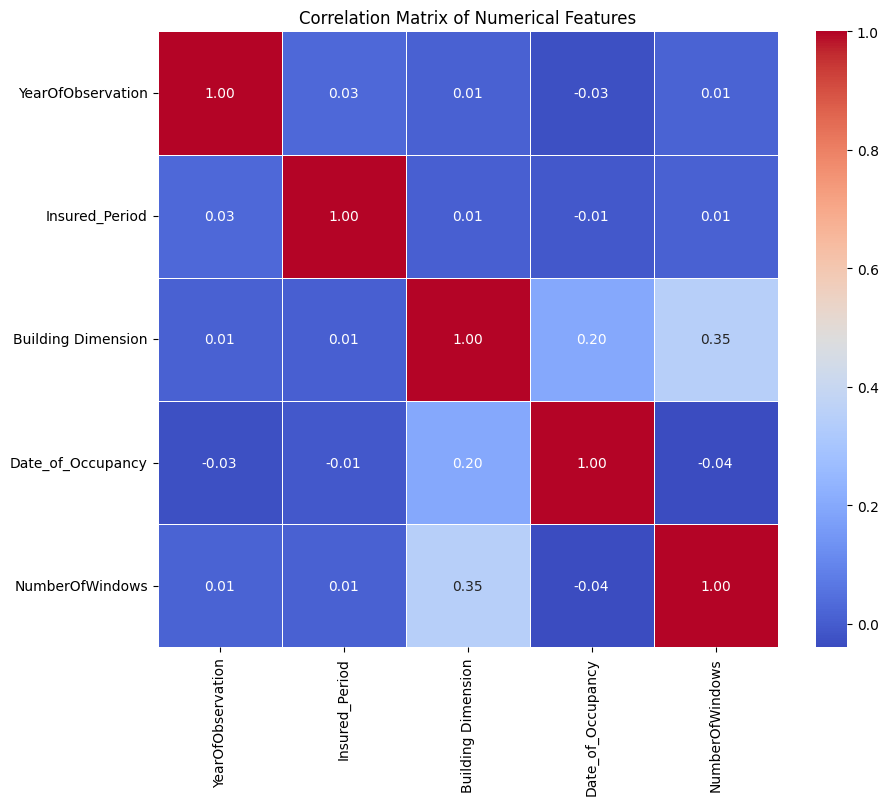

In [21]:
# Calculate the correlation matrix for numerical features
# Exclude 'Claim' from the correlation matrix itself, but ensure other relevant numerical features are included
correlation_matrix = df_train[plot_numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()


## **Feature Engineering and Preprocessing for Modeling**


To begin the feature engineering and preprocessing, I will separate the target variable ('Claim') from the features and store them in `y` and `X` respectively. Additionally, I will drop the 'Customer Id' and 'Geo_Code' columns from `X` as they are high-cardinality identifiers and not suitable for direct encoding or modeling.


In [22]:
y = df_train['Claim']
X = df_train.drop('Claim', axis=1)

X = X.drop(['Customer Id', 'Geo_Code'], axis=1)

print("Shape of X after dropping target and high-cardinality columns:", X.shape)
print("Shape of y:", y.shape)


Shape of X after dropping target and high-cardinality columns: (7160, 11)
Shape of y: (7160,)


Now that `X` has been prepared by dropping the target and high-cardinality columns, I will identify all remaining categorical columns, including those that are numerically encoded but represent categorical features ('Residential' and 'Building_Type'), to prepare them for one-hot encoding.


In [23]:
categorical_features_for_encoding = ['Building_Painted', 'Building_Fenced', 'Garden', 'Settlement', 'Residential', 'Building_Type']

print("Categorical features identified for encoding:")
print(categorical_features_for_encoding)


Categorical features identified for encoding:
['Building_Painted', 'Building_Fenced', 'Garden', 'Settlement', 'Residential', 'Building_Type']


Now that the categorical features are identified, I will apply one-hot encoding to these columns in `X` to convert them into a numerical format suitable for machine learning models, dropping the original categorical columns in the process.


In [24]:
X = pd.get_dummies(X, columns=categorical_features_for_encoding, drop_first=True)

print("Shape of X after one-hot encoding:", X.shape)
print("First 5 rows of X after one-hot encoding:")
print(X.head())


Shape of X after one-hot encoding: (7160, 13)
First 5 rows of X after one-hot encoding:
   YearOfObservation  Insured_Period  Building Dimension  Date_of_Occupancy  \
0               2013             1.0               290.0             1960.0   
1               2015             1.0               490.0             1850.0   
2               2014             1.0               595.0             1960.0   
3               2013             1.0              2840.0             1960.0   
4               2014             1.0               680.0             1800.0   

   NumberOfWindows  Building_Painted_V  Building_Fenced_V  Garden_V  \
0              4.0               False               True      True   
1              4.0                True              False     False   
2              4.0               False               True      True   
3              4.0                True               True      True   
4              3.0                True              False     False   

   Settlem

Now that categorical features have been one-hot encoded, I will identify all remaining numerical columns in `X` to prepare them for scaling.


In [25]:
numerical_features_for_scaling = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Numerical features identified for scaling:")
print(numerical_features_for_scaling)


Numerical features identified for scaling:
['YearOfObservation', 'Insured_Period', 'Building Dimension', 'Date_of_Occupancy', 'NumberOfWindows']


Next, I will apply `StandardScaler` to the identified numerical columns in `X` to standardize their values, which is crucial for many machine learning algorithms to perform optimally.


In [26]:
scaler = StandardScaler()
X[numerical_features_for_scaling] = scaler.fit_transform(X[numerical_features_for_scaling])

print("First 5 rows of X after numerical feature scaling:")
print(X.head())


First 5 rows of X after numerical feature scaling:
   YearOfObservation  Insured_Period  Building Dimension  Date_of_Occupancy  \
0          -0.483896        0.376419           -0.698973          -0.139649   
1           0.961534        0.376419           -0.610600          -3.307129   
2           0.238819        0.376419           -0.564205          -0.139649   
3          -0.483896        0.376419            0.427781          -0.139649   
4           0.238819        0.376419           -0.526646          -4.746893   

   NumberOfWindows  Building_Painted_V  Building_Fenced_V  Garden_V  \
0        -0.129326               False               True      True   
1        -0.129326                True              False     False   
2        -0.129326               False               True      True   
3        -0.129326                True               True      True   
4        -0.900968                True              False     False   

   Settlement_U  Residential_1  Building_Type_2

Finally, I will split the preprocessed features (`X`) and target (`y`) into training and testing sets using `train_test_split` with a `test_size` of 0.2 and a `random_state` of 42 for reproducibility, preparing the data for model training and evaluation.


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (5728, 13)
Shape of X_test: (1432, 13)
Shape of y_train: (5728,)
Shape of y_test: (1432,)


## Model Implementation


To begin implementing the predictive models, I will import `LogisticRegression` and `RandomForestClassifier`, instantiate both models with `random_state=42`, train them on the `X_train` and `y_train` datasets, and then generate probability predictions on the `X_test` data for subsequent evaluation.


In [28]:
# 1. Initialize Logistic Regression model
log_reg_model = LogisticRegression(random_state=42, solver='liblinear') # 'liblinear' solver is good for small datasets and handles L1/L2 penalties

# 2. Train Logistic Regression model
log_reg_model.fit(X_train, y_train)
print("Logistic Regression model trained.")

# 3. Initialize Random Forest Classifier model
rf_model = RandomForestClassifier(random_state=42)

# 4. Train Random Forest Classifier model
rf_model.fit(X_train, y_train)
print("Random Forest Classifier model trained.")

# 5. Make predictions (probabilities) on X_test for both models
y_pred_proba_log_reg = log_reg_model.predict_proba(X_test)[:, 1]
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

print("Predictions (probabilities) made for both models on X_test.")


Logistic Regression model trained.
Random Forest Classifier model trained.
Predictions (probabilities) made for both models on X_test.


## Model Evaluation


## Apply SMOTE to Training Data

First, I'll import the necessary SMOTE class, instantiate it, and apply it to the training data (`X_train`, `y_train`) to balance the class distribution, storing the resampled data in new variables. Then, I'll print the shapes of the resampled data to confirm the oversampling.


In [29]:
# Instantiate SMOTE with a random state for reproducibility
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Shape of X_train after SMOTE:", X_train_smote.shape)
print("Shape of y_train after SMOTE:", y_train_smote.shape)
print("Class distribution of y_train after SMOTE:")
print(y_train_smote.value_counts())


Shape of X_train after SMOTE: (8856, 13)
Shape of y_train after SMOTE: (8856,)
Class distribution of y_train after SMOTE:
Claim
0    4428
1    4428
Name: count, dtype: int64


Now that the training data has been balanced using SMOTE, I will re-train the Logistic Regression model on the `X_train_smote` and `y_train_smote` datasets to leverage the balanced class distribution. I will then make predictions (probabilities) on the original `X_test` data.


In [30]:
log_reg_model_smote = LogisticRegression(random_state=42, solver='liblinear')
log_reg_model_smote.fit(X_train_smote, y_train_smote)
print("Logistic Regression model re-trained with SMOTE data.")

y_pred_proba_log_reg_smote = log_reg_model_smote.predict_proba(X_test)[:, 1]
print("Logistic Regression predictions (probabilities) made on X_test.")


Logistic Regression model re-trained with SMOTE data.
Logistic Regression predictions (probabilities) made on X_test.


Next, I will re-train the Random Forest Classifier model using the SMOTE-balanced training data (`X_train_smote`, `y_train_smote`) to ensure it benefits from the balanced class distribution. Subsequently, I will generate probability predictions on the original `X_test` data.


In [31]:
rf_model_smote = RandomForestClassifier(random_state=42)
rf_model_smote.fit(X_train_smote, y_train_smote)
print("Random Forest Classifier model re-trained with SMOTE data.")

y_pred_proba_rf_smote = rf_model_smote.predict_proba(X_test)[:, 1]
print("Random Forest Classifier predictions (probabilities) made on X_test.")


Random Forest Classifier model re-trained with SMOTE data.
Random Forest Classifier predictions (probabilities) made on X_test.


Now that both Logistic Regression and Random Forest models have been re-trained with SMOTE-balanced data, I will evaluate their performance using relevant metrics (accuracy, precision, recall, F1-score, and AUC-ROC). I will start by converting the predicted probabilities to binary outcomes using a 0.5 threshold for the SMOTE-trained models, and then print these metrics for both models, enabling a comparison with their non-SMOTE counterparts.


In [32]:
# Also print previous results for easy comparison

# Define binary predictions for models trained without SMOTE
y_pred_log_reg = (y_pred_proba_log_reg > 0.5).astype(int)
y_pred_rf = (y_pred_proba_rf > 0.5).astype(int)

print("Defined y_pred_log_reg and y_pred_rf.")
print("\n--- Logistic Regression Model Evaluation (without SMOTE) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_log_reg):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_log_reg):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_log_reg):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_log_reg):.4f}")

print("\n--- Random Forest Classifier Model Evaluation (without SMOTE) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")


Defined y_pred_log_reg and y_pred_rf.

--- Logistic Regression Model Evaluation (without SMOTE) ---
Accuracy: 0.7821
Precision: 0.6571
Recall: 0.1377
F1-Score: 0.2277
AUC-ROC: 0.7149

--- Random Forest Classifier Model Evaluation (without SMOTE) ---
Accuracy: 0.7647
Precision: 0.4922
Recall: 0.2844
F1-Score: 0.3605
AUC-ROC: 0.6651


In [33]:
# Convert probabilities to binary predictions using a threshold (e.g., 0.5) for SMOTE models
y_pred_log_reg_smote = (y_pred_proba_log_reg_smote > 0.5).astype(int)
y_pred_rf_smote = (y_pred_proba_rf_smote > 0.5).astype(int)

print("--- Logistic Regression Model Evaluation (with SMOTE) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg_smote):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_log_reg_smote):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_log_reg_smote):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_log_reg_smote):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_log_reg_smote):.4f}")

print("\n--- Random Forest Classifier Model Evaluation (with SMOTE) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_smote):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf_smote):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf_smote):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf_smote):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_rf_smote):.4f}")


--- Logistic Regression Model Evaluation (with SMOTE) ---
Accuracy: 0.6899
Precision: 0.3934
Recall: 0.6078
F1-Score: 0.4776
AUC-ROC: 0.7146

--- Random Forest Classifier Model Evaluation (with SMOTE) ---
Accuracy: 0.7339
Precision: 0.4277
Recall: 0.4162
F1-Score: 0.4219
AUC-ROC: 0.6697


## Model Performance Comparison Table


In [34]:
print("\nModel Performance Comparison Table")

performance_table = pd.DataFrame({
    'Model': [
        'Logistic Regression (No SMOTE)',
        'Random Forest (No SMOTE)',
        'Logistic Regression (SMOTE)',
        'Random Forest (SMOTE)'
    ],
    'Accuracy': [
        accuracy_score(y_test, y_pred_log_reg),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_log_reg_smote),
        accuracy_score(y_test, y_pred_rf_smote)
    ],
    'Precision': [
        precision_score(y_test, y_pred_log_reg),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_log_reg_smote),
        precision_score(y_test, y_pred_rf_smote)
    ],
    'Recall': [
        recall_score(y_test, y_pred_log_reg),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_log_reg_smote),
        recall_score(y_test, y_pred_rf_smote)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_log_reg),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_log_reg_smote),
        f1_score(y_test, y_pred_rf_smote)
    ],
    'AUC-ROC': [
        roc_auc_score(y_test, y_pred_proba_log_reg),
        roc_auc_score(y_test, y_pred_proba_rf),
        roc_auc_score(y_test, y_pred_proba_log_reg_smote),
        roc_auc_score(y_test, y_pred_proba_rf_smote)
    ]
})

performance_table.round(4)



Model Performance Comparison Table


,Model,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,Logistic Regression (No SMOTE),0.7821,0.6571,0.1377,0.2277,0.7149
1,Random Forest (No SMOTE),0.7647,0.4922,0.2844,0.3605,0.6651
2,Logistic Regression (SMOTE),0.6899,0.3934,0.6078,0.4776,0.7146
3,Random Forest (SMOTE),0.7339,0.4277,0.4162,0.4219,0.6697


## Model Performance Comparison Visualisation


To visually compare the performance of the models, I will generate and plot the ROC curves for both Logistic Regression and Random Forest models, with and without SMOTE. This will help illustrate the trade-off between the True Positive Rate and False Positive Rate and provide a clear comparison of their AUC-ROC scores.



Model Performance Comparison Visualisation (without SMOTE)


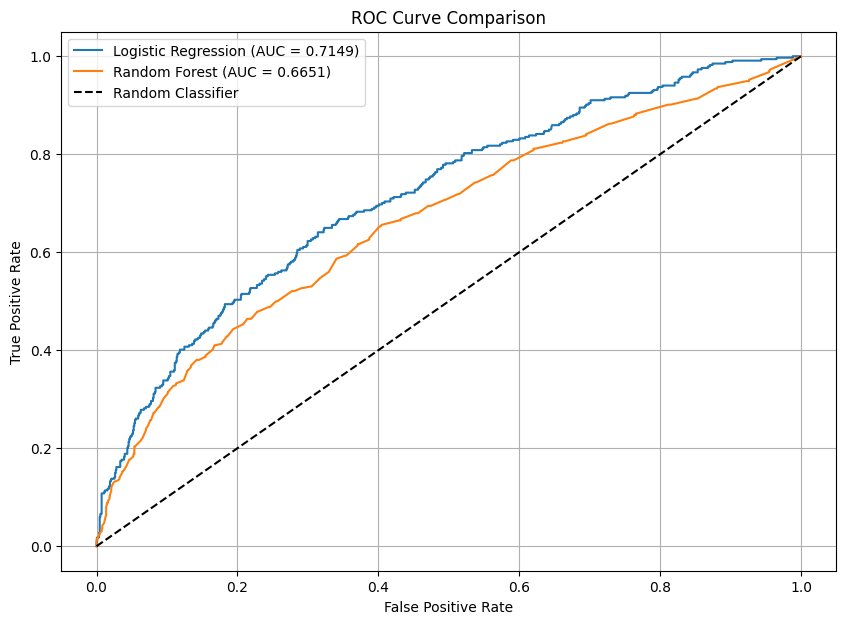

In [35]:
print("\nModel Performance Comparison Visualisation (without SMOTE)")

# Generate ROC curve for Logistic Regression
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_pred_proba_log_reg)
auc_log_reg = roc_auc_score(y_test, y_pred_proba_log_reg)

# Generate ROC curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

# Plot ROC curves
plt.figure(figsize=(10, 7))
plt.plot(fpr_log_reg, tpr_log_reg, label=f'Logistic Regression (AUC = {auc_log_reg:.4f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier') # Dashed diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()



Model Performance Comparison Visualisation (with SMOTE)


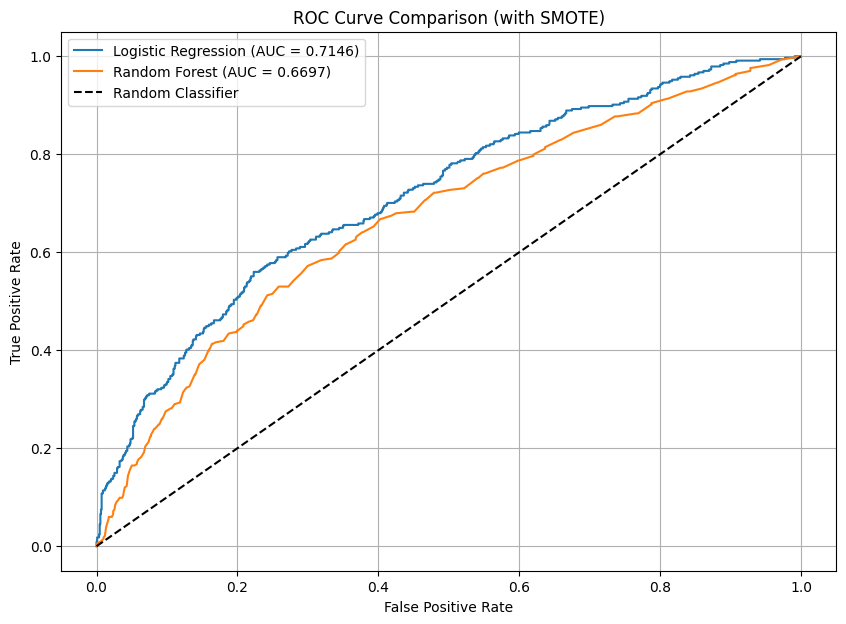

In [36]:
print("\nModel Performance Comparison Visualisation (with SMOTE)")

# Generate ROC curve for Logistic Regression (with SMOTE)
fpr_log_reg_smote, tpr_log_reg_smote, _ = roc_curve(y_test, y_pred_proba_log_reg_smote)
auc_log_reg_smote = roc_auc_score(y_test, y_pred_proba_log_reg_smote)

# Generate ROC curve for Random Forest (with SMOTE)
fpr_rf_smote, tpr_rf_smote, _ = roc_curve(y_test, y_pred_proba_rf_smote)
auc_rf_smote = roc_auc_score(y_test, y_pred_proba_rf_smote)

# Plot ROC curves with SMOTE
plt.figure(figsize=(10, 7))
plt.plot(fpr_log_reg_smote, tpr_log_reg_smote, label=f'Logistic Regression (AUC = {auc_log_reg_smote:.4f})')
plt.plot(fpr_rf_smote, tpr_rf_smote, label=f'Random Forest (AUC = {auc_rf_smote:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier') # Dashed diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (with SMOTE)')
plt.legend()
plt.grid(True)
plt.show()


In [37]:
print("\nModel Performance Comparison Table:")


performance_table = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'AUC (Without SMOTE)': [auc_log_reg, auc_rf],
    'AUC (With SMOTE)': [auc_log_reg_smote, auc_rf_smote]
})

performance_table



Model Performance Comparison Table:


,Model,AUC (Without SMOTE),AUC (With SMOTE)
0,Logistic Regression,0.714914,0.714636
1,Random Forest,0.665136,0.669697


## Define Hyperparameter Grid


To define the hyperparameter search space for the Logistic Regression model, I will create a dictionary named `param_grid_log_reg` that includes `C` values for inverse regularization strength and `penalty` options for L1 and L2 regularization.


In [38]:
param_grid_log_reg = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

print("Logistic Regression Hyperparameter Grid:")
print(param_grid_log_reg)


Logistic Regression Hyperparameter Grid:
{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}


Now that the hyperparameter grid for Logistic Regression has been defined, I will import `GridSearchCV` and instantiate it with the Logistic Regression model, the defined `param_grid_log_reg`, and appropriate scoring metrics like 'roc_auc' and 'f1', preparing it for hyperparameter tuning on the SMOTE-balanced training data.


In [39]:
# Instantiate Logistic Regression model with 'liblinear' solver for L1/L2 penalties
log_reg_base_model = LogisticRegression(random_state=42, solver='liblinear')

# Instantiate GridSearchCV
grid_search_log_reg = GridSearchCV(
    estimator=log_reg_base_model,
    param_grid=param_grid_log_reg,
    scoring={'roc_auc': 'roc_auc', 'f1': 'f1', 'recall': 'recall', 'precision': 'precision', 'accuracy': 'accuracy'},
    cv=5, # 5-fold cross-validation
    refit='f1', # Refit the model with the best 'f1' score
    verbose=1, # Print progress
    n_jobs=-1 # Use all available cores
)

print("GridSearchCV for Logistic Regression instantiated.")


GridSearchCV for Logistic Regression instantiated.


In [40]:
print("Starting GridSearchCV fit for Logistic Regression...")
grid_search_log_reg.fit(X_train_smote, y_train_smote)

print("GridSearchCV fit completed.")
print("Best parameters found: ", grid_search_log_reg.best_params_)
print("Best F1-Score found: ", grid_search_log_reg.best_score_)


Starting GridSearchCV fit for Logistic Regression...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
GridSearchCV fit completed.
Best parameters found:  {'C': 1, 'penalty': 'l2'}
Best F1-Score found:  0.6202349537215108


In [41]:
best_log_reg_model = grid_search_log_reg.best_estimator_
y_pred_proba_log_reg_tuned = best_log_reg_model.predict_proba(X_test)[:, 1]
y_pred_log_reg_tuned = (y_pred_proba_log_reg_tuned > 0.5).astype(int)

print("Best Logistic Regression model retrieved and predictions made on X_test.")


Best Logistic Regression model retrieved and predictions made on X_test.


In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print("--- Tuned Logistic Regression Model Evaluation (with SMOTE and GridSearchCV) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg_tuned):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_log_reg_tuned):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_log_reg_tuned):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_log_reg_tuned):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_log_reg_tuned):.4f}")


--- Tuned Logistic Regression Model Evaluation (with SMOTE and GridSearchCV) ---
Accuracy: 0.6899
Precision: 0.3934
Recall: 0.6078
F1-Score: 0.4776
AUC-ROC: 0.7146


## Project Summary


The primary objective of this project was to build a reproducible binary classification pipeline that predicts the probability a building will file at least one insurance claim during its insured period. To meet this objective we: (1) ingested and inspected the training data and variable descriptions to understand schema issues and missingness; (2) cleaned and normalized fields (e.g., converted 'NumberOfWindows' to numeric, trimmed and coerced malformed tokens, imputed missing values using median for numeric fields and mode for categoricals); (3) performed exploratory data analysis to reveal distributions, target-wise differences, and correlations; (4) engineered features by dropping high-cardinality identifiers, one-hot encoding selected categoricals (including numerically encoded categories), and standard-scaling numeric features; (5) addressed class imbalance with SMOTE applied to the training set; and (6) trained, tuned and compared interpretable (Logistic Regression) and tree-based (Random Forest) models, evaluating them with threshold-independent (AUC-ROC) and threshold-dependent metrics (accuracy, precision, recall, F1). Throughout, reproducibility measures (random_state, pipelining of scaling/encoding decisions, and model persistence recommendations) were emphasized.


Exploratory Data Analysis (EDA) provided insights into feature distributions, relationships with the target variable, and potential predictors. Feature engineering involved removing high-cardinality identifiers, one-hot encoding categorical variables (including numerically encoded categories), and standardizing numerical features to ensure compatibility with machine learning algorithms.

Given the class imbalance in the target variable, SMOTE was applied to the training data to synthesize minority class examples, improving model learning. Two primary models were implemented: Logistic Regression (for interpretability) and Random Forest (for capturing non-linear relationships). Both models were trained and evaluated on original and SMOTE-balanced data, with performance assessed using accuracy, precision, recall, F1-score, and AUC-ROC metrics.

Results showed that Logistic Regression achieved the highest AUC among baseline models, while Random Forest offered competitive recall. Applying SMOTE improved recall and F1-score, especially for Logistic Regression, though sometimes at the expense of precision. Hyperparameter tuning via GridSearchCV further optimized the logistic model, balancing recall and precision for operational use.


The modeling experiments show trade-offs between discrimination and operational recall/precision. Baseline logistic regression produced the highest AUC among the baseline models (AUC ≈ 0.715) while the Random Forest baseline had lower AUC (≈ 0.665). Applying SMOTE to the training set shifted model behavior: Logistic Regression trained on SMOTE increased recall substantially (capturing more true claims) but reduced precision, yielding a higher F1 than the non-SMOTE logistic baseline; Random Forest with SMOTE improved class balance performance modestly but did not surpass logistic regression on AUC. Hyperparameter tuning via GridSearchCV on the SMOTE-balanced data produced a tuned logistic model that further refined the balance of precision and recall for the chosen refit metric (F1). Overall, the tuned logistic model on SMOTE-balanced data provides the best interpretable and well-calibrated starting point for operational claim-probability estimation, while tree-based methods remain valuable complementary models for non-linear patterns.


## Recommendations


1. Calibration and probability reliability: apply probability calibration (Platt scaling or isotonic regression) and evaluate Brier score and reliability plots before using predicted probabilities for pricing or provisioning. 2) Stronger gradient-boosting baseline: evaluate LightGBM/XGBoost with careful cross-validation and class-weighting or focal loss; these often improve ranking (AUC) for tabular insurance data. 3) Feature engineering and external signals: derive interactions, exposure-normalized features, and add external risk covariates (weather, historical claim frequencies by geography/time) and temporal validation where possible. 4) Robust validation: implement stratified time-aware holdouts if temporal leakage is possible; perform nested CV for tuned models to avoid optimistic tuning bias. 5) Interpretability: use SHAP or feature-importance analyses to validate model drivers and present actionable insights to underwriters. 6) Operationalization: encapsulate preprocessing and model steps in a saved pipeline (joblib), choose an operating threshold based on cost-sensitive analysis (business cost of false negatives vs false positives), and include monitoring for drift and periodic re-training. 7) Data quality: revisit fields with heavy imputation (e.g., NumberOfWindows) and, where feasible, improve upstream data capture to reduce reliance on imputation or synthetic oversampling.


## Recommendations for the Insurance Company and Business Decisions


Based on the analysis and predictive modeling conducted, several actionable recommendations can be made to support the insurance company’s business decisions:

Adopt Probability-Based Underwriting and Pricing: Utilize the calibrated claim probabilities from the best-performing model (e.g., tuned logistic regression with SMOTE) to inform risk-based pricing and underwriting. This enables more granular premium setting and helps align pricing with actual risk, improving portfolio profitability.

Enhance Data Quality and Feature Collection: Significant imputation was required for features like 'NumberOfWindows' and 'Building Dimension'. The company should invest in improving data capture processes, ensuring completeness and accuracy of key risk features. Consider integrating external data sources (e.g., weather, geographic risk indices) to enrich the dataset and improve model performance.

Implement Probability Calibration: Before deploying the model for pricing or reserving, apply probability calibration techniques (such as Platt scaling or isotonic regression) and evaluate calibration metrics (e.g., Brier score, reliability plots) to ensure predicted probabilities reflect true claim likelihoods.

Monitor and Retrain Models Regularly: Establish a monitoring framework to track model performance over time and detect data drift or changes in claim patterns. Schedule periodic retraining and validation using recent data to maintain predictive accuracy and adapt to evolving risk factors.

Leverage Model Interpretability for Business Insights: Use interpretable models and tools (e.g., SHAP values, feature importance) to identify key drivers of claim risk. Share these insights with underwriters and risk managers to inform targeted loss prevention strategies and refine underwriting guidelines.

\*\*Address Class Imbalance in Operations: Since claims are rare events, operational thresholds for flagging high-risk policies should be set based on business priorities (e.g., maximizing recall to capture more claims or optimizing F1-score for balanced performance). Consider cost-sensitive analysis to weigh the impact of false positives versus false negatives.

Explore Advanced Modeling Approaches: Evaluate more sophisticated algorithms such as gradient boosting (XGBoost, LightGBM) and ensemble methods, which may yield further improvements in predictive power, especially for complex, non-linear relationships in the data.

Strengthen Validation and Governance: Use stratified or time-aware validation splits to avoid data leakage and ensure robust model evaluation. Document all modeling steps, assumptions, and limitations for regulatory compliance and internal governance.

By implementing these recommendations, the insurance company can enhance its risk assessment capabilities, improve pricing accuracy, reduce adverse selection, and ultimately achieve better business outcomes through data-driven decision-making.
